<center><h1>Predicting players rating</h1></center>

In [87]:
import os
import sqlite3
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

In [88]:
# To use SQLite3 in Python, Create a connection object which will connect us to the database and will let us execute the SQL statements.
conn = sqlite3.connect('database.sqlite')

# To execute SQLite statements in Python, you need a cursor object. You can create it using the cursor() method.
cur = conn.cursor()

# Now we can use the cursor object to call the execute() method to execute any SQL queries.

In [89]:
# cur.execute("select * from Player_Attributes")
# rows = cur.fetchall()
# # for row in rows:
# #     print(row)
# print(rows)
df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [90]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [91]:
df.shape

(183978, 42)

In [92]:
df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

In [93]:
df.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,183978.00000,183978.000000,183978.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000,181265.000000,...,181265.000000,183142.000000,183142.000000,183142.000000,181265.000000,183142.000000,183142.000000,183142.000000,183142.000000,183142.000000
mean,91989.50000,165671.524291,135900.617324,68.600015,73.460353,55.086883,49.921078,57.266023,62.429672,49.468436,...,57.873550,55.003986,46.772242,50.351257,48.001462,14.704393,16.063612,20.998362,16.132154,16.441439
std,53110.01825,53851.094769,136927.840510,7.041139,6.592271,17.242135,19.038705,16.488905,14.194068,18.256618,...,15.144086,15.546519,21.227667,21.483706,21.598778,16.865467,15.867382,21.452980,16.099175,17.198155
min,1.00000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,45995.25000,155798.000000,34763.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,91989.50000,183488.000000,77741.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,137983.75000,199848.000000,191080.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,183978.00000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,96.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.000000


In [94]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [95]:
# print column names in readable format
[(f"column {i+1} : {column}") for i,column in enumerate(df.columns)]

['column 1 : id',
 'column 2 : player_fifa_api_id',
 'column 3 : player_api_id',
 'column 4 : date',
 'column 5 : overall_rating',
 'column 6 : potential',
 'column 7 : preferred_foot',
 'column 8 : attacking_work_rate',
 'column 9 : defensive_work_rate',
 'column 10 : crossing',
 'column 11 : finishing',
 'column 12 : heading_accuracy',
 'column 13 : short_passing',
 'column 14 : volleys',
 'column 15 : dribbling',
 'column 16 : curve',
 'column 17 : free_kick_accuracy',
 'column 18 : long_passing',
 'column 19 : ball_control',
 'column 20 : acceleration',
 'column 21 : sprint_speed',
 'column 22 : agility',
 'column 23 : reactions',
 'column 24 : balance',
 'column 25 : shot_power',
 'column 26 : jumping',
 'column 27 : stamina',
 'column 28 : strength',
 'column 29 : long_shots',
 'column 30 : aggression',
 'column 31 : interceptions',
 'column 32 : positioning',
 'column 33 : vision',
 'column 34 : penalties',
 'column 35 : marking',
 'column 36 : standing_tackle',
 'column 37 : sl

## Data Preprocessing

In [96]:
#Create a new dataframe after dropping some columns which are not useful to predict player overall ratings
soccer_data = df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis = 1)

In [97]:
#Check whether there are duplicates entries present or not
soccer_data.duplicated().any()

True

In [98]:
#Drop duplicates entries from soccer_data dataframe
soccer_data.drop_duplicates(inplace=True)

#check dataframe shape after dropping duplicate entries
soccer_data.shape

(138440, 38)

In [99]:
soccer_data.isnull().sum()

overall_rating            1
potential                 1
preferred_foot            1
attacking_work_rate    1812
defensive_work_rate       1
crossing                  1
finishing                 1
heading_accuracy          1
short_passing             1
volleys                1482
dribbling                 1
curve                  1482
free_kick_accuracy        1
long_passing              1
ball_control              1
acceleration              1
sprint_speed              1
agility                1482
reactions                 1
balance                1482
shot_power                1
jumping                1482
stamina                   1
strength                  1
long_shots                1
aggression                1
interceptions             1
positioning               1
vision                 1482
penalties                 1
marking                   1
standing_tackle           1
sliding_tackle         1482
gk_diving                 1
gk_handling               1
gk_kicking          

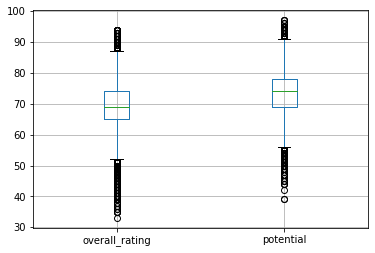

In [100]:
# df.boxplot()
soccer_data.boxplot(column=['overall_rating','potential'])

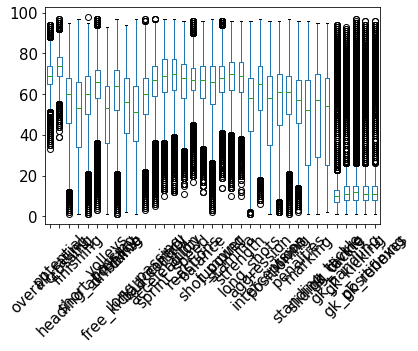

In [101]:
soccer_data.boxplot(grid=False, rot=45, fontsize=15)

In [102]:
# Check the distribution of loan amount
# IQR - for outlier detection
Q1 = soccer_data["overall_rating"].quantile(0.25)
Q3 = soccer_data["overall_rating"].quantile(0.75)
IQR = Q3 - Q1
print("upper bound",Q3 + 1.5 * IQR)
print("upper bound",Q1 - 1.5 * IQR)


upper bound 87.5
upper bound 51.5


In [103]:
#Check for Outliers 
IQR_check =(soccer_data["overall_rating"] < (Q1 - 1.5 * IQR)) | (soccer_data["overall_rating"] > (Q3 + 1.5 * IQR))
print("Total outlier data points based on IQR Rule:",soccer_data.loc[IQR_check,:].shape[0])
soccer_data.loc[IQR_check,:]


## Flooring
soccer_data.loc[soccer_data["overall_rating"] < (Q1 - 1.5 * IQR),"overall_rating"] = soccer_data["overall_rating"].quantile(0.05)

## Capping 
print(df["overall_rating"].quantile(0.95))
soccer_data.loc[soccer_data["overall_rating"] > (Q3 + 1.5 * IQR),"overall_rating"] = soccer_data["overall_rating"].quantile(0.95)


Total outlier data points based on IQR Rule: 1571
80.0


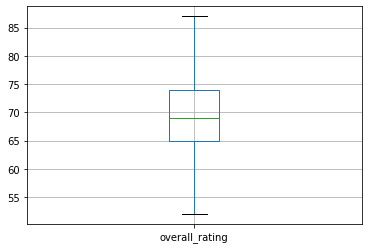

In [105]:
soccer_data.boxplot(column=['overall_rating'])

In [106]:
# Check the distribution of loan amount
# IQR - for outlier detection
p_Q1 = soccer_data["potential"].quantile(0.25)
p_Q3 = soccer_data["potential"].quantile(0.75)
p_IQR = p_Q3 - p_Q1
print("upper bound",p_Q3 + 1.5 * p_IQR)
print("lower bound",p_Q1 - 1.5 * p_IQR)
#Check for  Capping  Outliers top
p_IQR_check =(soccer_data["potential"] < (p_Q1 - 1.5 * p_IQR)) | (soccer_data["potential"] > (p_Q3 + 1.5 * p_IQR))
print("Total outlier data points based on IQR Rule:",soccer_data.loc[p_IQR_check,:].shape[0])
soccer_data.loc[p_IQR_check,:]




## Flooring
soccer_data.loc[soccer_data["potential"] < (p_Q1 - 1.5 * p_IQR),"potential"] = soccer_data["potential"].quantile(0.05)

## Capping 
# print(df["potential"].quantile(0.95))
soccer_data.loc[soccer_data["potential"] > (p_Q3 + 1.5 * p_IQR),"potential"] = soccer_data["potential"].quantile(0.95)


upper bound 91.5
lower bound 55.5
Total outlier data points based on IQR Rule: 543


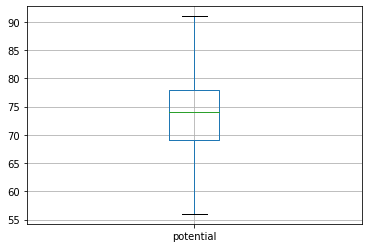

In [108]:
soccer_data.boxplot(column=['potential'])

In [110]:
 soccer_data.isnull().sum()

overall_rating            1
potential                 1
preferred_foot            1
attacking_work_rate    1812
defensive_work_rate       1
crossing                  1
finishing                 1
heading_accuracy          1
short_passing             1
volleys                1482
dribbling                 1
curve                  1482
free_kick_accuracy        1
long_passing              1
ball_control              1
acceleration              1
sprint_speed              1
agility                1482
reactions                 1
balance                1482
shot_power                1
jumping                1482
stamina                   1
strength                  1
long_shots                1
aggression                1
interceptions             1
positioning               1
vision                 1482
penalties                 1
marking                   1
standing_tackle           1
sliding_tackle         1482
gk_diving                 1
gk_handling               1
gk_kicking          

In [111]:
def data_preprocessing(df):
    df.convert_objects(convert_numeric=True)
    df.fillna(-99999, inplace=True)     
    return df

#call function to hanbdle missing data
data_preprocessing(soccer_data)

#check number of missing parameters in the DataFrame - Columnwise after handling missing data (should be 0)
soccer_data.isnull().values.sum()

C:\Users\kjk\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


0

In [59]:
# soccer_data['overall_rating'].fillna(soccer_data['overall_rating'].mean(), inplace = True)
# soccer_data['potential'].fillna(soccer_data['potential'].mean(), inplace = True)
# # df["preferred_foot"].fillna(df["preferred_foot"].mode().values(), inplace=True)

# soccer_data['preferred_foot'].fillna(soccer_data['preferred_foot'].mode().values[0], inplace = True)
# # df["preferred_foot"].isnull().sum()
# soccer_data['attacking_work_rate'].fillna(soccer_data['attacking_work_rate'].mode().values[0], inplace = True)
# # attacking_work_rate
# # soccer_data["attacking_work_rate"].isnull().sum()
# soccer_data['defensive_work_rate'].fillna(soccer_data['defensive_work_rate'].mode().values[0], inplace = True)
# # defensive_work_rate
# # df['defensive_work_rate'].isnull().sum()
# soccer_data['crossing'].fillna(soccer_data['crossing'].mean(), inplace = True)
# # crossing
# # df['crossing'].isnull().sum()
# soccer_data['finishing'].fillna(soccer_data['finishing'].mean(), inplace = True)
# # finishing
# soccer_data['heading_accuracy'].fillna(soccer_data['heading_accuracy'].mean(), inplace = True)
# soccer_data['short_passing'].fillna(soccer_data['short_passing'].mean(), inplace = True)
# soccer_data['volleys'].fillna(soccer_data['volleys'].mean(), inplace = True)
# soccer_data['dribbling'].fillna(soccer_data['dribbling'].mean(), inplace = True)
# soccer_data['curve'].fillna(soccer_data['curve'].mean(), inplace = True)
# soccer_data['free_kick_accuracy'].fillna(soccer_data['free_kick_accuracy'].mean(), inplace = True)
# soccer_data['long_passing'].fillna(soccer_data['long_passing'].mean(), inplace = True)
# soccer_data['ball_control'].fillna(soccer_data['ball_control'].mean(), inplace = True)
# soccer_data['acceleration'].fillna(soccer_data['acceleration'].mean(), inplace = True)
# soccer_data['sprint_speed'].fillna(soccer_data['sprint_speed'].mean(), inplace = True)
# soccer_data['agility'].fillna(soccer_data['agility'].mean(), inplace = True)
# soccer_data['reactions'].fillna(soccer_data['reactions'].mean(), inplace = True)
# soccer_data['balance'].fillna(soccer_data['balance'].mean(), inplace = True)
# soccer_data['shot_power'].fillna(soccer_data['shot_power'].mean(), inplace = True)
# soccer_data['jumping'].fillna(soccer_data['jumping'].mean(), inplace = True)
# soccer_data['stamina'].fillna(soccer_data['stamina'].mean(), inplace = True)
# soccer_data['strength'].fillna(soccer_data['strength'].mean(), inplace = True)
# soccer_data['long_shots'].fillna(soccer_data['long_shots'].mean(), inplace = True)
# soccer_data['aggression'].fillna(soccer_data['aggression'].mean(), inplace = True)
# soccer_data['interceptions'].fillna(soccer_data['interceptions'].mean(), inplace = True)
# soccer_data['positioning'].fillna(soccer_data['positioning'].mean(), inplace = True)
# soccer_data['vision'].fillna(soccer_data['vision'].mean(), inplace = True)
# soccer_data['penalties'].fillna(soccer_data['penalties'].mean(), inplace = True)
# soccer_data['marking'].fillna(soccer_data['marking'].mean(), inplace = True)
# soccer_data['standing_tackle'].fillna(soccer_data['standing_tackle'].mean(), inplace = True)
# soccer_data['sliding_tackle'].fillna(soccer_data['sliding_tackle'].mean(), inplace = True)
# soccer_data['gk_diving'].fillna(soccer_data['gk_diving'].mean(), inplace = True)
# soccer_data['gk_handling'].fillna(soccer_data['gk_handling'].mean(), inplace = True)
# soccer_data['gk_kicking'].fillna(soccer_data['gk_kicking'].mean(), inplace = True)
# soccer_data['gk_positioning'].fillna(soccer_data['gk_positioning'].mean(), inplace = True)
# soccer_data['gk_reflexes'].fillna(soccer_data['gk_reflexes'].mean(), inplace = True)

In [112]:
soccer_data.isnull().sum()

overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0
gk_kicking             0
gk_positioning         0
gk_reflexes            0
dtype: int64

In [114]:
soccer_data = pd.get_dummies(soccer_data)
soccer_data.head(1)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,0,0,0,0,0,0,1,0,0,0


In [115]:
soccer_data.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
count,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,...,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000,138440.000000
mean,68.643058,73.291000,54.801914,49.471641,57.050195,62.239367,-1021.132274,58.760712,-1017.740393,49.060488,...,0.000845,0.013081,0.000621,0.000730,0.154226,0.099191,0.707563,0.009715,0.002124,0.000506
std,269.027448,269.036713,269.475747,269.585690,269.438570,269.309300,10296.052731,269.519877,10296.405470,269.500618,...,0.029059,0.113624,0.024916,0.027001,0.361166,0.298919,0.454884,0.098087,0.046034,0.022481
min,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,-99999.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,65.000000,69.000000,46.000000,34.000000,50.000000,58.000000,35.000000,52.000000,41.000000,37.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,74.000000,60.000000,53.000000,60.000000,66.000000,53.000000,64.000000,56.000000,51.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,74.000000,78.000000,68.000000,66.000000,69.000000,72.000000,64.000000,72.000000,67.000000,64.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,87.000000,91.000000,95.000000,97.000000,98.000000,97.000000,93.000000,97.000000,94.000000,97.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


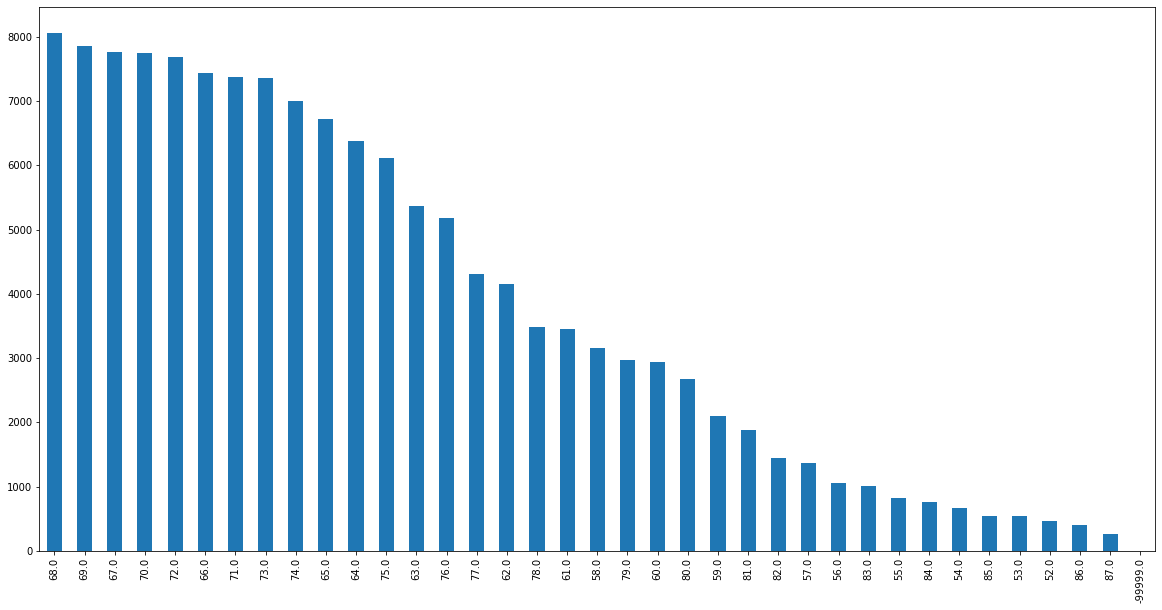

In [116]:
soccer_data['overall_rating'].value_counts()

soccer_data['overall_rating'].value_counts().plot(kind='bar',figsize=(20,10))

Text(0.5, 1, 'soccer_data.corr()')

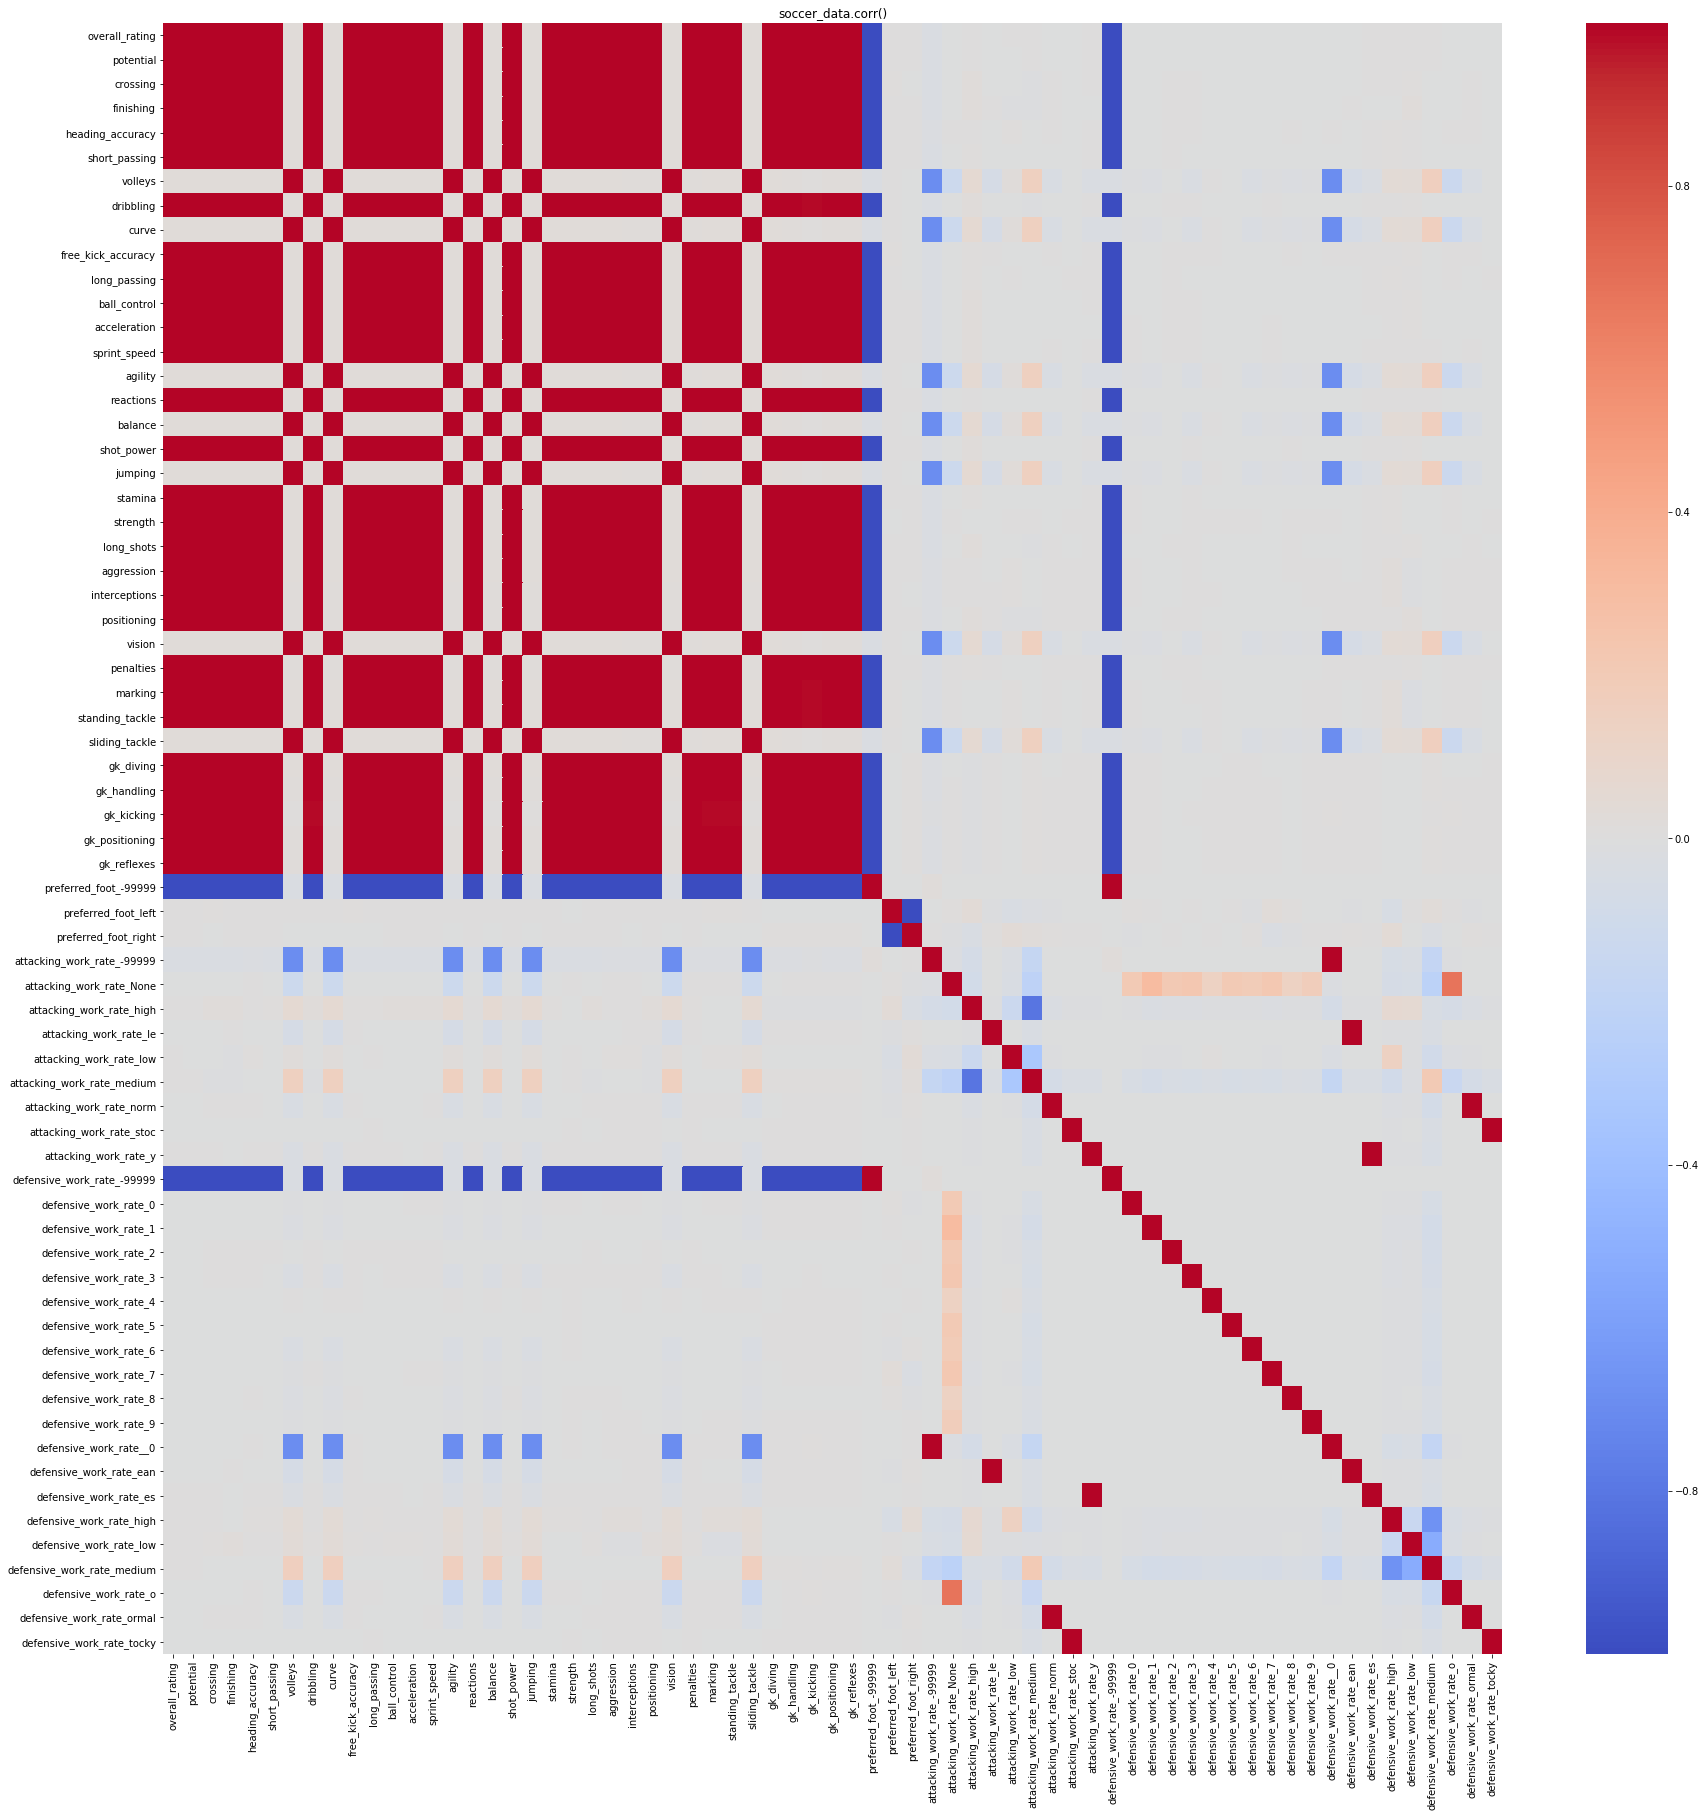

In [117]:
## Correlation plot:
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(soccer_data.corr(),cmap='coolwarm',ax=ax)
plt.title('soccer_data.corr()')

In [119]:
#Split dataframe into df_x and df_y
df_x = soccer_data.drop(['overall_rating'], 1)
df_y = np.array(soccer_data['overall_rating'])

In [120]:
#Use RandomForestRegressor to check feature_importances
rfc_1 = RandomForestRegressor(random_state=10)
rfc_1.fit(df_x, df_y)

feature_importances = pd.DataFrame({'feature':df_x.columns,'importance':np.round(rfc_1.feature_importances_,4)})
feature_importances = feature_importances.sort_values('importance',ascending=False).set_index('feature')

C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [121]:
print(feature_importances[:35])

                        importance
feature                           
gk_kicking                  0.2001
ball_control                0.1056
positioning                 0.1010
crossing                    0.1008
dribbling                   0.1006
strength                    0.1004
long_passing                0.1002
penalties                   0.1002
reactions                   0.0504
potential                   0.0218
standing_tackle             0.0045
gk_diving                   0.0029
heading_accuracy            0.0016
gk_positioning              0.0015
marking                     0.0013
shot_power                  0.0010
finishing                   0.0010
interceptions               0.0006
short_passing               0.0005
gk_handling                 0.0005
gk_reflexes                 0.0004
long_shots                  0.0004
aggression                  0.0003
sliding_tackle              0.0003
sprint_speed                0.0003
acceleration                0.0003
stamina             

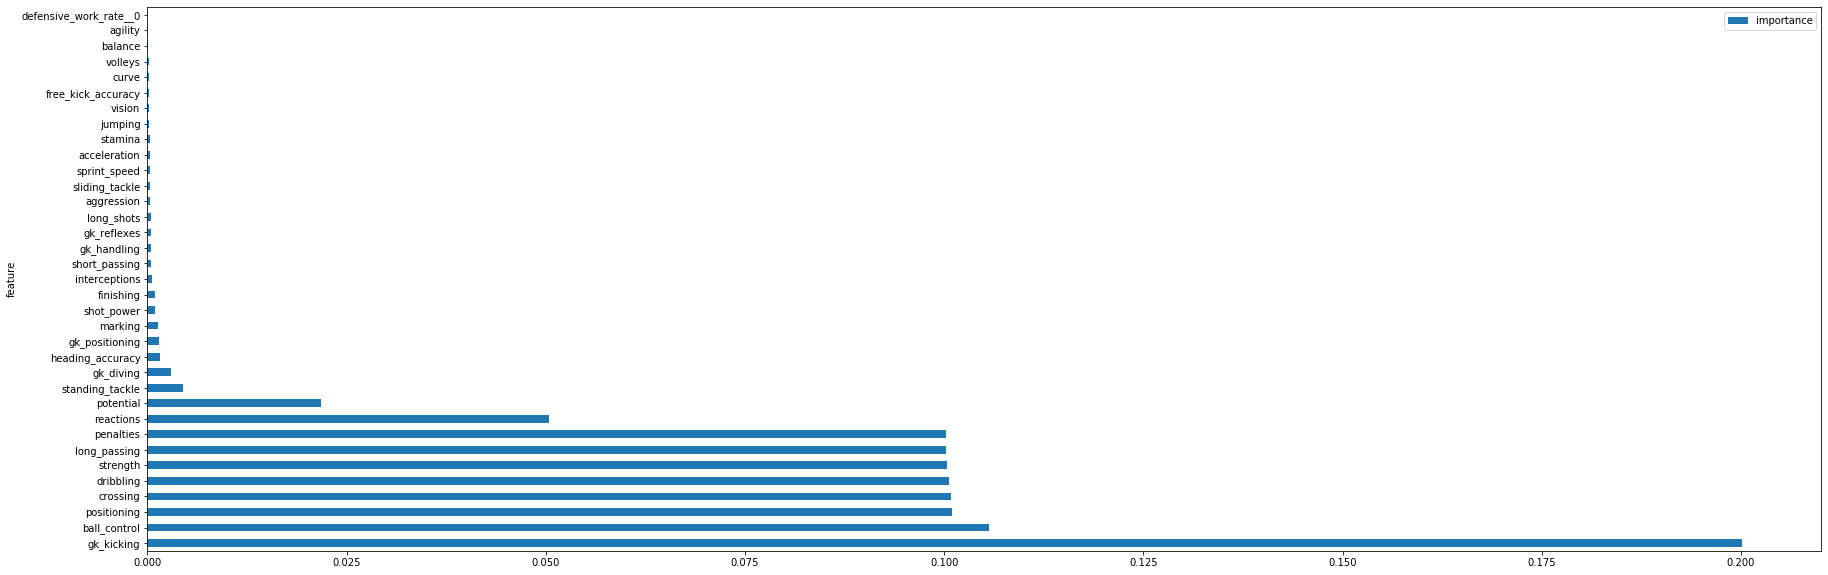

In [122]:
#Visualize top 35 features of the dataframe
feature_importances[:35].plot(kind='barh',figsize=(30,10))

### Create dataset for train, test and cross-validation

In [123]:
x, x_test, y, y_test = train_test_split(df_x,df_y,test_size=0.2,train_size=0.8, random_state = 55)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.20,train_size =0.80, random_state = 55)

In [124]:
#Apply linear regression model on the dataset
lr1 = LinearRegression()
lr = RFE(lr1, 20)
lr.fit(x_train,y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=20, step=1, verbose=0)

In [128]:
models = pd.DataFrame(index=['train_mse','cv_mse','test_mse','accuracy_score'], columns=['linear_regression'])
# models = pd.DataFrame(index=['train_mse','cv_mse','test_mse','accuracy_score'], columns=['linear_regression','decision_tree','random_forest','xgboost'])

In [129]:
models.loc['train_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_train), y_true=y_train)
models.loc['cv_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_cv), y_true=y_cv)
models.loc['test_mse','linear_regression'] = mean_squared_error(y_pred=lr.predict(x_test), y_true=y_test)
models.loc['accuracy_score','linear_regression'] = accuracy_score(y_pred=lr.predict(x_test).round(), y_true=y_test)

In [130]:
models

,linear_regression
train_mse,42.2994
cv_mse,41.6059
test_mse,42.686
accuracy_score,0.057245
